In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

from torch.utils.data import Dataset
import os
from PIL import Image


# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"



In [2]:
no_train = False
fashion = True
batch_size = 10
n_epochs = 20
lr = 0.001

image_width = 112
image_height = 112

./face/2.jpg


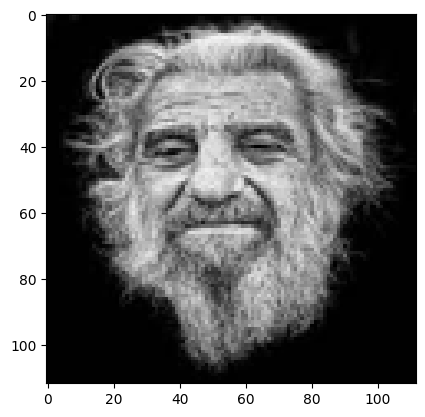

In [3]:
class MyDataset(Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = [os.path.join(root_dir, image) for image in os.listdir(root_dir)]
        print(self.images[0])
        image = Image.open(self.images[3])
        image = image.resize((image_width, image_height))
        plt.imshow(image)
        plt.show()

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        image = image.resize((image_width, image_height))
        #numpy_image = np.array(image)
        #image = torch.tensor(numpy_image) #.view(3, 28, 28)
        # Convert the image to grayscale
        grayscale_image = image.convert('L')
        numpy_image = np.array(grayscale_image)
        # Convert the image to a tensor
        tensor = torch.from_numpy(numpy_image)

        # Reshape the tensor
        tensor = tensor.view(1, *tensor.size())
        
        #print(tensor.shape)
        return tensor

    def __len__(self):
        return len(self.images)

dataset = MyDataset("./face")
loader = torch.utils.data.DataLoader(dataset, batch_size=10)


In [4]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [5]:
def show_first_batch(loader):
    for batch in loader:
        print(len(batch))
        print(batch.shape)
        show_images(batch, "Images in the first batch")
        break

10
torch.Size([10, 1, 112, 112])


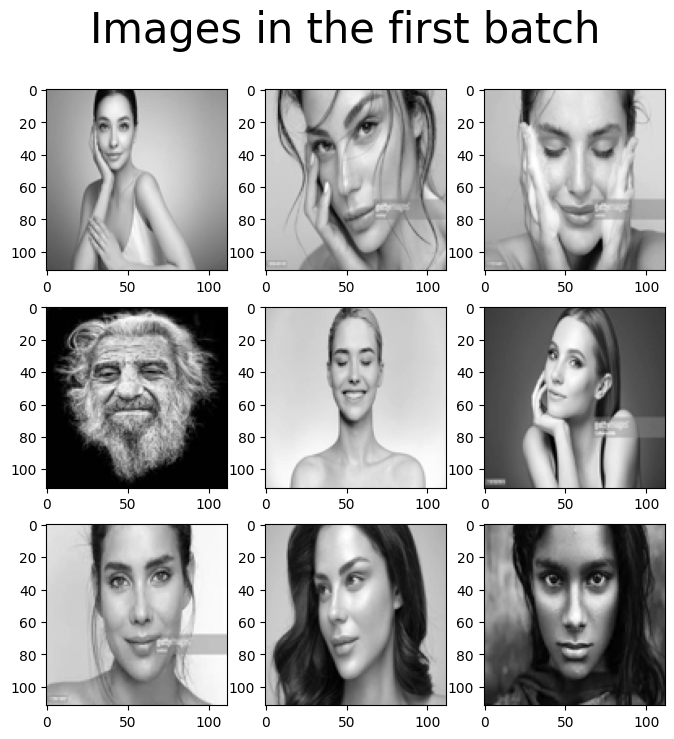

In [6]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [7]:
def show_first_batch(loader):
    for batch in loader:
        print(len(batch))
        print(batch[0].shape)
        
        show_images(batch, "Images in the first batch")
        #print(batch.shape)
        break

10
torch.Size([1, 112, 112])


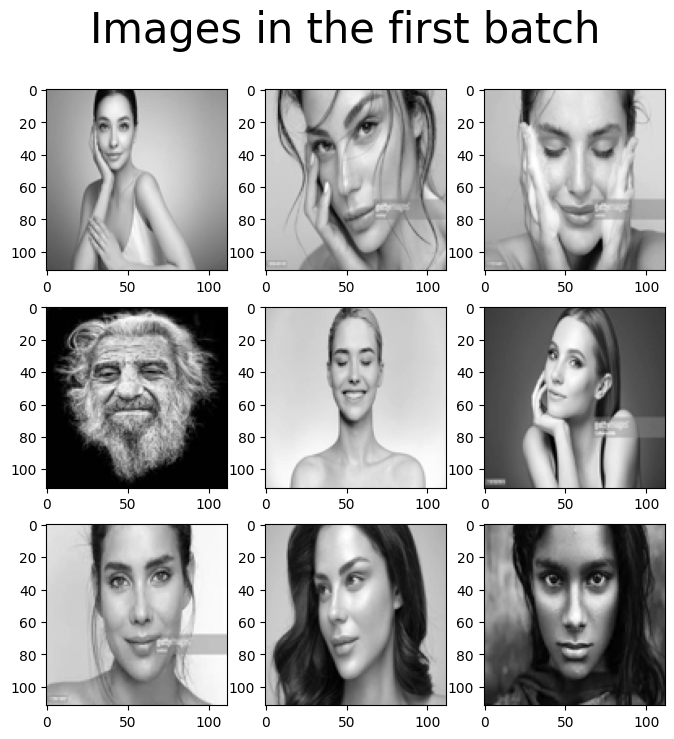

In [8]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [9]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce GTX 1080 Ti


In [10]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=1000, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, image_width, image_height)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta * 30
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [11]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch

        show_images(imgs, "Original images")

        for percent in [0.20, 0.40, 0.60, 0.80, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [12]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=image_width, w=image_height):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        
        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

In [13]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [14]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [15]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 112, 112), 1, 10),
            MyBlock((10, 112, 112), 10, 10),
            MyBlock((10, 112, 112), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 56, 56), 10, 20),
            MyBlock((20, 56, 56), 20, 20),
            MyBlock((20, 56, 56), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 28, 28), 20, 40),
            MyBlock((40, 28, 28), 40, 40),
            MyBlock((40, 28, 28), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 13, 13), 40, 20),
            MyBlock((20, 13, 13), 20, 20),
            MyBlock((20, 13, 13), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 28, 28), 80, 40),
            MyBlock((40, 28, 28), 40, 20),
            MyBlock((20, 28, 28), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 56, 56), 40, 20),
            MyBlock((20, 56, 56), 20, 10),
            MyBlock((10, 56, 56), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 112, 112), 20, 10),
            MyBlock((10, 112, 112), 10, 10),
            MyBlock((10, 112, 112), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)
        #print(out_mid.shape)
        #print(out3.shape)
        #print(self.up1(out_mid).shape)
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [16]:
# Defining model
n_steps, min_beta, max_beta = 1000, 0.0001, 0.02 # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

ddpm.load_state_dict(torch.load("./ddpm_face.pt"))

<All keys matched successfully>

In [17]:
sum([p.numel() for p in ddpm.parameters()])

3132012

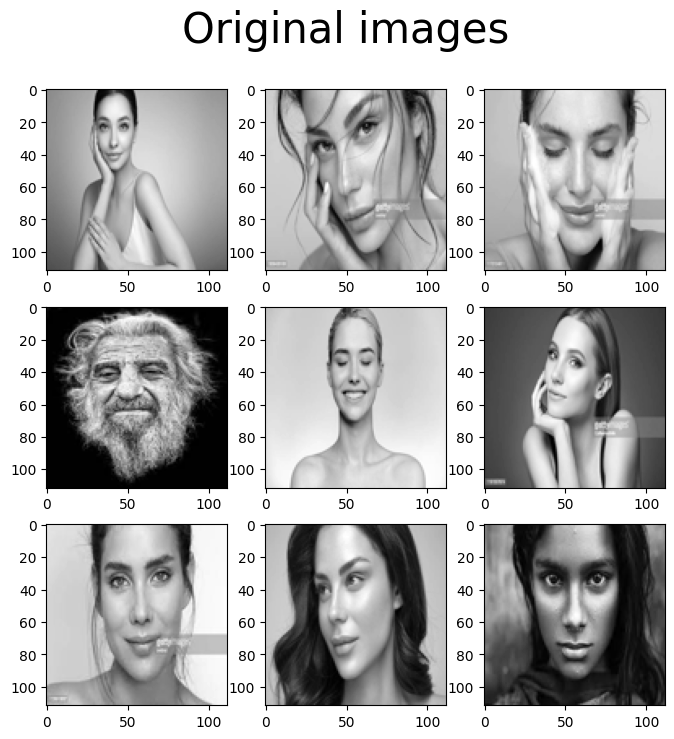

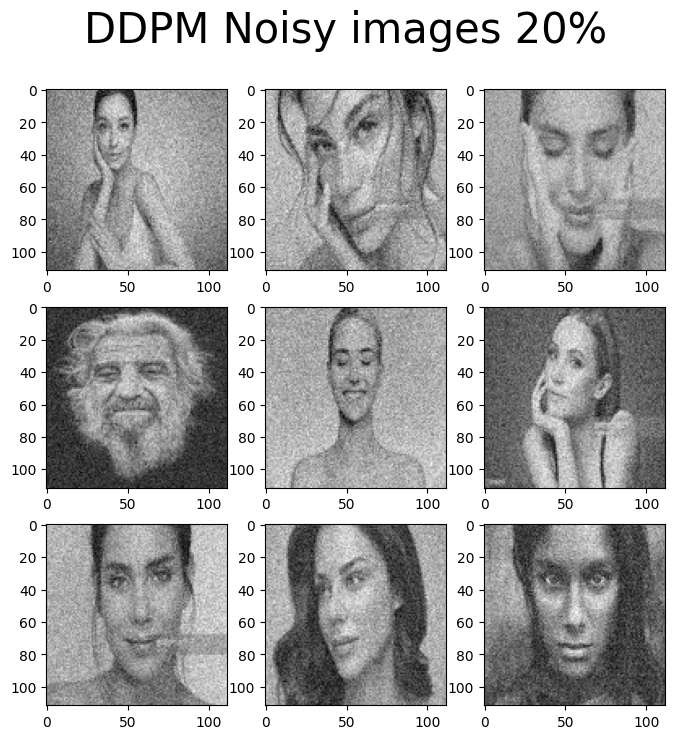

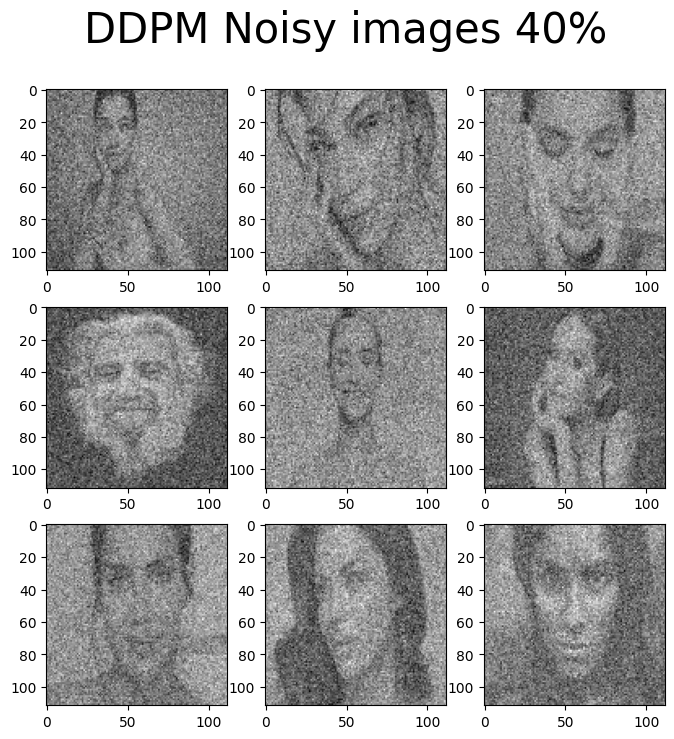

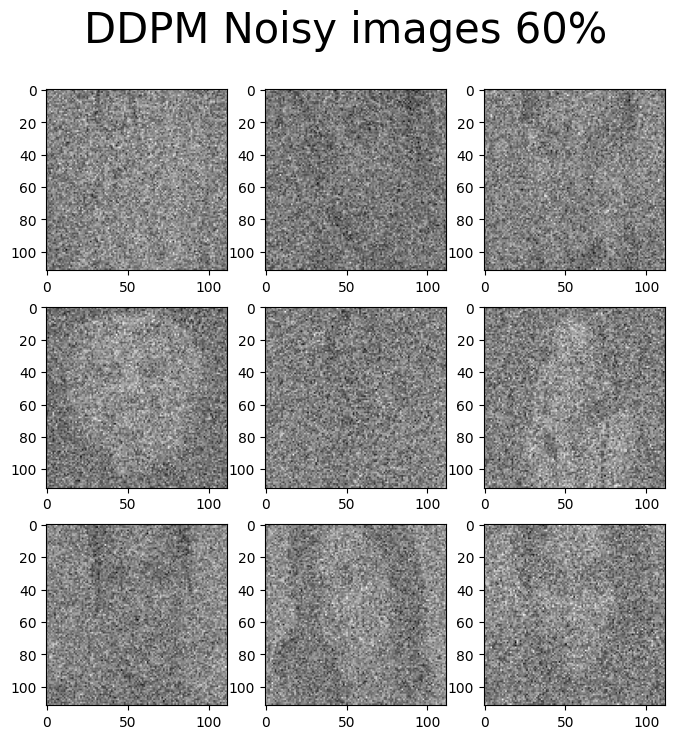

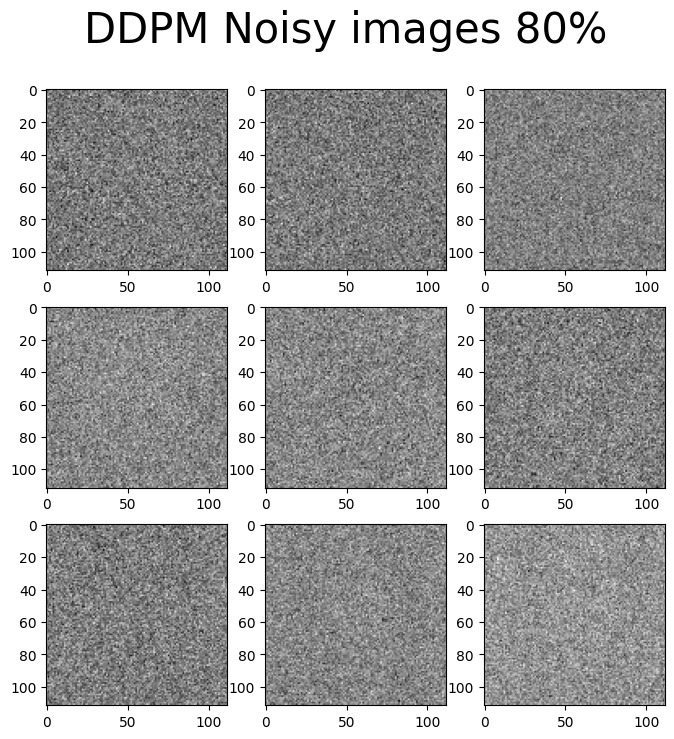

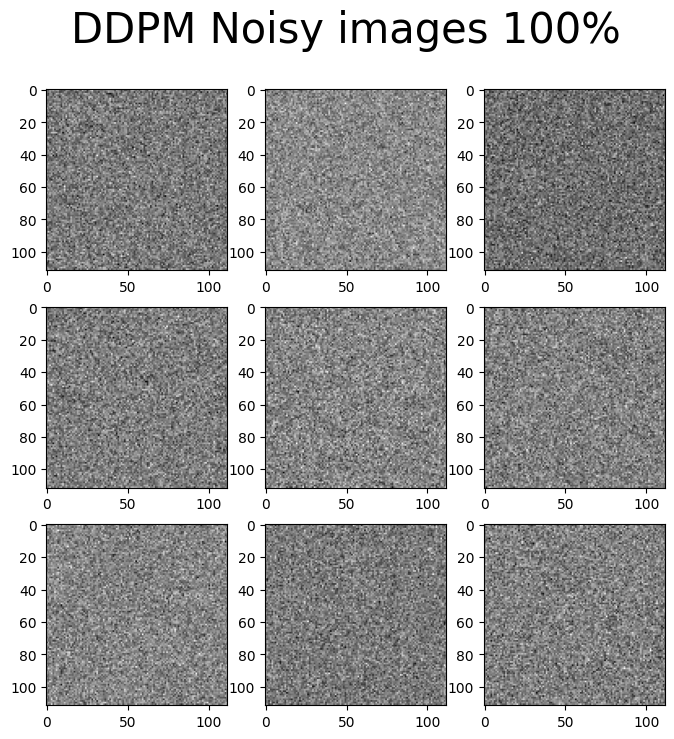

In [18]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

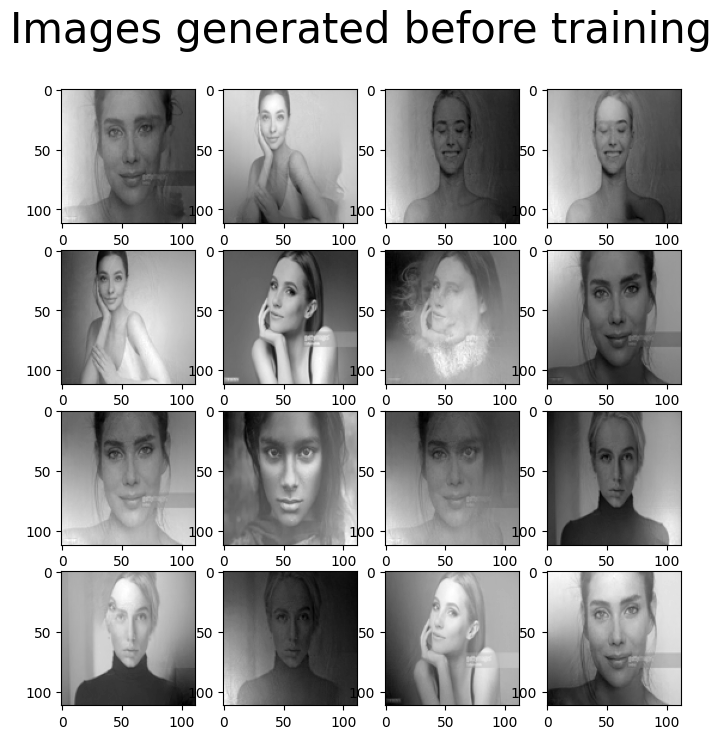

In [18]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [22]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}")):
            # Loading data
            x0 = batch.to(device)
            n = len(x0)
            x0 = x0.float()
            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.5f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [23]:
# Training
store_path = "ddpm_face.pt" 
fashion = True
batch_size = 128
n_epochs = 3000
lr = 0.0001
if not no_train:
    training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1: 0.00478 --> Best model ever (stored)


Epoch 2/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2: 0.00499


Epoch 3/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3: 0.00314 --> Best model ever (stored)


Epoch 4/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 4: 0.00942


Epoch 5/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 5: 0.00539


Epoch 6/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 6: 0.00381


Epoch 7/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 7: 0.00634


Epoch 8/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 8: 0.01222


Epoch 9/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 9: 0.00390


Epoch 10/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 10: 0.00543


Epoch 11/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 11: 0.00668


Epoch 12/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 12: 0.00448


Epoch 13/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 13: 0.00375


Epoch 14/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 14: 0.00390


Epoch 15/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 15: 0.00445


Epoch 16/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 16: 0.00329


Epoch 17/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 17: 0.00771


Epoch 18/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 18: 0.00424


Epoch 19/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 19: 0.01780


Epoch 20/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 20: 0.00438


Epoch 21/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 21: 0.00527


Epoch 22/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 22: 0.00630


Epoch 23/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 23: 0.00766


Epoch 24/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 24: 0.00321


Epoch 25/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 25: 0.00392


Epoch 26/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 26: 0.00562


Epoch 27/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 27: 0.00399


Epoch 28/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 28: 0.02787


Epoch 29/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 29: 0.00909


Epoch 30/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 30: 0.00454


Epoch 31/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 31: 0.00710


Epoch 32/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 32: 0.00653


Epoch 33/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 33: 0.04903


Epoch 34/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 34: 0.00361


Epoch 35/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 35: 0.01592


Epoch 36/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 36: 0.00636


Epoch 37/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 37: 0.01012


Epoch 38/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 38: 0.01094


Epoch 39/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 39: 0.00340


Epoch 40/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 40: 0.00320


Epoch 41/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 41: 0.00594


Epoch 42/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 42: 0.00752


Epoch 43/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 43: 0.00581


Epoch 44/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 44: 0.03314


Epoch 45/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 45: 0.00358


Epoch 46/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 46: 0.00497


Epoch 47/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 47: 0.00522


Epoch 48/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 48: 0.00798


Epoch 49/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 49: 0.00808


Epoch 50/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 50: 0.00626


Epoch 51/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 51: 0.01236


Epoch 52/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 52: 0.00351


Epoch 53/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 53: 0.00583


Epoch 54/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 54: 0.00873


Epoch 55/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 55: 0.00497


Epoch 56/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 56: 0.00372


Epoch 57/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 57: 0.00394


Epoch 58/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 58: 0.00320


Epoch 59/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 59: 0.00693


Epoch 60/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 60: 0.00534


Epoch 61/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 61: 0.00754


Epoch 62/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 62: 0.01623


Epoch 63/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 63: 0.00614


Epoch 64/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 64: 0.00389


Epoch 65/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 65: 0.00518


Epoch 66/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 66: 0.00979


Epoch 67/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 67: 0.00767


Epoch 68/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 68: 0.00547


Epoch 69/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 69: 0.00718


Epoch 70/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 70: 0.00390


Epoch 71/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 71: 0.00503


Epoch 72/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 72: 0.00502


Epoch 73/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 73: 0.00756


Epoch 74/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 74: 0.05945


Epoch 75/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 75: 0.00881


Epoch 76/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 76: 0.00792


Epoch 77/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 77: 0.00424


Epoch 78/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 78: 0.00480


Epoch 79/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 79: 0.00578


Epoch 80/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 80: 0.00690


Epoch 81/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 81: 0.00495


Epoch 82/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 82: 0.00383


Epoch 83/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 83: 0.01094


Epoch 84/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 84: 0.01179


Epoch 85/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 85: 0.00403


Epoch 86/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 86: 0.00743


Epoch 87/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 87: 0.00774


Epoch 88/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 88: 0.00414


Epoch 89/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 89: 0.00368


Epoch 90/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 90: 0.00955


Epoch 91/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 91: 0.00346


Epoch 92/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 92: 0.00432


Epoch 93/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 93: 0.00709


Epoch 94/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 94: 0.00367


Epoch 95/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 95: 0.01167


Epoch 96/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 96: 0.00436


Epoch 97/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 97: 0.00324


Epoch 98/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 98: 0.03262


Epoch 99/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 99: 0.00393


Epoch 100/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 100: 0.00533


Epoch 101/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 101: 0.00488


Epoch 102/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 102: 0.00457


Epoch 103/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 103: 0.03582


Epoch 104/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 104: 0.00357


Epoch 105/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 105: 0.01524


Epoch 106/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 106: 0.00672


Epoch 107/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 107: 0.00958


Epoch 108/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 108: 0.00337


Epoch 109/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 109: 0.00492


Epoch 110/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 110: 0.00380


Epoch 111/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 111: 0.00437


Epoch 112/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 112: 0.00381


Epoch 113/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 113: 0.00532


Epoch 114/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 114: 0.00440


Epoch 115/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 115: 0.01149


Epoch 116/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 116: 0.00533


Epoch 117/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 117: 0.01156


Epoch 118/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 118: 0.00537


Epoch 119/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 119: 0.00390


Epoch 120/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 120: 0.01238


Epoch 121/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 121: 0.00485


Epoch 122/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 122: 0.00599


Epoch 123/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 123: 0.00463


Epoch 124/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 124: 0.00481


Epoch 125/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 125: 0.00506


Epoch 126/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 126: 0.00541


Epoch 127/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 127: 0.00593


Epoch 128/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 128: 0.00419


Epoch 129/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 129: 0.00527


Epoch 130/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 130: 0.00590


Epoch 131/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 131: 0.00478


Epoch 132/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 132: 0.00469


Epoch 133/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 133: 0.00597


Epoch 134/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 134: 0.00432


Epoch 135/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 135: 0.00603


Epoch 136/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 136: 0.00440


Epoch 137/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 137: 0.00363


Epoch 138/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 138: 0.00320


Epoch 139/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 139: 0.00650


Epoch 140/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 140: 0.00473


Epoch 141/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 141: 0.00367


Epoch 142/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 142: 0.00505


Epoch 143/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 143: 0.00365


Epoch 144/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 144: 0.00465


Epoch 145/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 145: 0.00673


Epoch 146/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 146: 0.00616


Epoch 147/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 147: 0.00490


Epoch 148/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 148: 0.00809


Epoch 149/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 149: 0.00590


Epoch 150/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 150: 0.00452


Epoch 151/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 151: 0.00447


Epoch 152/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 152: 0.01014


Epoch 153/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 153: 0.00574


Epoch 154/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 154: 0.00367


Epoch 155/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 155: 0.00372


Epoch 156/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 156: 0.00514


Epoch 157/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 157: 0.00400


Epoch 158/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 158: 0.00426


Epoch 159/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 159: 0.00419


Epoch 160/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 160: 0.00700


Epoch 161/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 161: 0.00451


Epoch 162/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 162: 0.00394


Epoch 163/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 163: 0.00511


Epoch 164/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 164: 0.00470


Epoch 165/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 165: 0.00657


Epoch 166/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 166: 0.00470


Epoch 167/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 167: 0.00565


Epoch 168/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 168: 0.00342


Epoch 169/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 169: 0.00378


Epoch 170/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 170: 0.01193


Epoch 171/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 171: 0.04370


Epoch 172/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 172: 0.00572


Epoch 173/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 173: 0.00310 --> Best model ever (stored)


Epoch 174/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 174: 0.01651


Epoch 175/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 175: 0.00486


Epoch 176/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 176: 0.00361


Epoch 177/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 177: 0.00693


Epoch 178/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 178: 0.04290


Epoch 179/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 179: 0.00460


Epoch 180/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 180: 0.00523


Epoch 181/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 181: 0.00330


Epoch 182/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 182: 0.00460


Epoch 183/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 183: 0.01103


Epoch 184/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 184: 0.00597


Epoch 185/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 185: 0.00695


Epoch 186/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 186: 0.00526


Epoch 187/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 187: 0.00439


Epoch 188/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 188: 0.00458


Epoch 189/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 189: 0.00614


Epoch 190/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 190: 0.00424


Epoch 191/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 191: 0.00917


Epoch 192/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 192: 0.00821


Epoch 193/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 193: 0.00550


Epoch 194/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 194: 0.00381


Epoch 195/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 195: 0.00660


Epoch 196/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 196: 0.00506


Epoch 197/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 197: 0.00533


Epoch 198/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 198: 0.00433


Epoch 199/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 199: 0.00388


Epoch 200/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 200: 0.00417


Epoch 201/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 201: 0.00829


Epoch 202/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 202: 0.00861


Epoch 203/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 203: 0.00460


Epoch 204/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 204: 0.00292 --> Best model ever (stored)


Epoch 205/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 205: 0.00410


Epoch 206/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 206: 0.00494


Epoch 207/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 207: 0.00577


Epoch 208/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 208: 0.00511


Epoch 209/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 209: 0.00800


Epoch 210/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 210: 0.00516


Epoch 211/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 211: 0.00291 --> Best model ever (stored)


Epoch 212/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 212: 0.00365


Epoch 213/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 213: 0.00447


Epoch 214/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 214: 0.00991


Epoch 215/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 215: 0.00457


Epoch 216/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 216: 0.00504


Epoch 217/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 217: 0.00399


Epoch 218/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 218: 0.00503


Epoch 219/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 219: 0.00401


Epoch 220/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 220: 0.00469


Epoch 221/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 221: 0.00344


Epoch 222/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 222: 0.00416


Epoch 223/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 223: 0.04642


Epoch 224/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 224: 0.00390


Epoch 225/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 225: 0.00704


Epoch 226/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 226: 0.00563


Epoch 227/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 227: 0.00374


Epoch 228/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 228: 0.00649


Epoch 229/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 229: 0.00424


Epoch 230/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 230: 0.00776


Epoch 231/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 231: 0.00553


Epoch 232/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 232: 0.00789


Epoch 233/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 233: 0.00884


Epoch 234/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 234: 0.00774


Epoch 235/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 235: 0.00373


Epoch 236/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 236: 0.00461


Epoch 237/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 237: 0.00447


Epoch 238/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 238: 0.00811


Epoch 239/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 239: 0.00367


Epoch 240/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 240: 0.00772


Epoch 241/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 241: 0.00871


Epoch 242/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 242: 0.00343


Epoch 243/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 243: 0.00409


Epoch 244/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 244: 0.00494


Epoch 245/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 245: 0.00817


Epoch 246/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 246: 0.00472


Epoch 247/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 247: 0.00467


Epoch 248/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 248: 0.00330


Epoch 249/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 249: 0.00728


Epoch 250/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 250: 0.00421


Epoch 251/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 251: 0.00873


Epoch 252/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 252: 0.00456


Epoch 253/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 253: 0.03748


Epoch 254/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 254: 0.00733


Epoch 255/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 255: 0.00340


Epoch 256/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 256: 0.00363


Epoch 257/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 257: 0.00507


Epoch 258/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 258: 0.00763


Epoch 259/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 259: 0.00471


Epoch 260/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 260: 0.01391


Epoch 261/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 261: 0.00709


Epoch 262/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 262: 0.00436


Epoch 263/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 263: 0.00527


Epoch 264/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 264: 0.00348


Epoch 265/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 265: 0.00888


Epoch 266/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 266: 0.03054


Epoch 267/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 267: 0.00622


Epoch 268/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 268: 0.00469


Epoch 269/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 269: 0.00612


Epoch 270/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 270: 0.00298


Epoch 271/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 271: 0.00327


Epoch 272/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 272: 0.00730


Epoch 273/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 273: 0.04684


Epoch 274/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 274: 0.00606


Epoch 275/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 275: 0.05676


Epoch 276/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 276: 0.00402


Epoch 277/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 277: 0.00371


Epoch 278/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 278: 0.00690


Epoch 279/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 279: 0.00503


Epoch 280/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 280: 0.00435


Epoch 281/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 281: 0.00433


Epoch 282/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 282: 0.00435


Epoch 283/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 283: 0.01735


Epoch 284/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 284: 0.00664


Epoch 285/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 285: 0.00682


Epoch 286/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 286: 0.00352


Epoch 287/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 287: 0.00763


Epoch 288/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 288: 0.00321


Epoch 289/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 289: 0.00360


Epoch 290/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 290: 0.00516


Epoch 291/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 291: 0.00445


Epoch 292/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 292: 0.00343


Epoch 293/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 293: 0.00651


Epoch 294/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 294: 0.00450


Epoch 295/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 295: 0.00890


Epoch 296/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 296: 0.00336


Epoch 297/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 297: 0.00490


Epoch 298/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 298: 0.00407


Epoch 299/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 299: 0.00589


Epoch 300/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 300: 0.00342


Epoch 301/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 301: 0.00603


Epoch 302/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 302: 0.00516


Epoch 303/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 303: 0.00459


Epoch 304/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 304: 0.00530


Epoch 305/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 305: 0.00637


Epoch 306/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 306: 0.00332


Epoch 307/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 307: 0.00485


Epoch 308/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 308: 0.00496


Epoch 309/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 309: 0.00438


Epoch 310/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 310: 0.00504


Epoch 311/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 311: 0.00575


Epoch 312/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 312: 0.00422


Epoch 313/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 313: 0.00482


Epoch 314/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 314: 0.00958


Epoch 315/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 315: 0.00523


Epoch 316/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 316: 0.00493


Epoch 317/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 317: 0.00417


Epoch 318/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 318: 0.00394


Epoch 319/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 319: 0.00802


Epoch 320/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 320: 0.00334


Epoch 321/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 321: 0.05293


Epoch 322/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 322: 0.00720


Epoch 323/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 323: 0.00383


Epoch 324/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 324: 0.00739


Epoch 325/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 325: 0.00642


Epoch 326/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 326: 0.00506


Epoch 327/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 327: 0.00347


Epoch 328/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 328: 0.00424


Epoch 329/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 329: 0.00714


Epoch 330/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 330: 0.00559


Epoch 331/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 331: 0.00596


Epoch 332/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 332: 0.00508


Epoch 333/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 333: 0.00490


Epoch 334/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 334: 0.01133


Epoch 335/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 335: 0.00724


Epoch 336/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 336: 0.00737


Epoch 337/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 337: 0.00324


Epoch 338/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 338: 0.00502


Epoch 339/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 339: 0.02096


Epoch 340/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 340: 0.00372


Epoch 341/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 341: 0.00368


Epoch 342/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 342: 0.00594


Epoch 343/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 343: 0.00408


Epoch 344/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 344: 0.00511


Epoch 345/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 345: 0.00531


Epoch 346/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 346: 0.00736


Epoch 347/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 347: 0.00548


Epoch 348/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 348: 0.00602


Epoch 349/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 349: 0.02178


Epoch 350/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 350: 0.00452


Epoch 351/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 352: 0.00644


Epoch 353/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 353: 0.00431


Epoch 354/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 354: 0.00562


Epoch 355/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 355: 0.00334


Epoch 356/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 356: 0.00574


Epoch 357/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 357: 0.00453


Epoch 358/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 358: 0.00574


Epoch 359/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 359: 0.00504


Epoch 360/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 360: 0.00399


Epoch 361/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 361: 0.00739


Epoch 362/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 362: 0.00344


Epoch 363/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 363: 0.01145


Epoch 364/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 364: 0.00512


Epoch 365/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 365: 0.00621


Epoch 366/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 366: 0.00458


Epoch 367/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 367: 0.00375


Epoch 368/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 368: 0.00313


Epoch 369/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 369: 0.05260


Epoch 370/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 370: 0.00533


Epoch 371/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 371: 0.00387


Epoch 372/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 372: 0.00425


Epoch 373/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 373: 0.01896


Epoch 374/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 374: 0.01676


Epoch 375/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 375: 0.00448


Epoch 376/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 376: 0.00417


Epoch 377/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 377: 0.01337


Epoch 378/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 378: 0.00337


Epoch 379/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 379: 0.00583


Epoch 380/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 380: 0.00396


Epoch 381/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 381: 0.00663


Epoch 382/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 382: 0.00303


Epoch 383/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 383: 0.01010


Epoch 384/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 384: 0.00711


Epoch 385/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 385: 0.00617


Epoch 386/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 386: 0.00467


Epoch 387/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 387: 0.00431


Epoch 388/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 388: 0.00458


Epoch 389/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 389: 0.00481


Epoch 390/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 390: 0.00406


Epoch 391/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 391: 0.00416


Epoch 392/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 392: 0.00590


Epoch 393/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 393: 0.00442


Epoch 394/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 394: 0.00427


Epoch 395/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 395: 0.00453


Epoch 396/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 396: 0.00490


Epoch 397/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 397: 0.00518


Epoch 398/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 398: 0.00499


Epoch 399/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 399: 0.00563


Epoch 400/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 400: 0.00443


Epoch 401/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 401: 0.00354


Epoch 402/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 402: 0.00561


Epoch 403/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 403: 0.00564


Epoch 404/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 404: 0.00296


Epoch 405/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 405: 0.01139


Epoch 406/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 406: 0.00576


Epoch 407/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 407: 0.06630


Epoch 408/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 408: 0.00473


Epoch 409/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 409: 0.00554


Epoch 410/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 410: 0.01589


Epoch 411/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 411: 0.00742


Epoch 412/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 412: 0.00342


Epoch 413/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 413: 0.00365


Epoch 414/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 414: 0.00612


Epoch 415/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 415: 0.00495


Epoch 416/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 416: 0.00395


Epoch 417/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 417: 0.00487


Epoch 418/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 418: 0.00669


Epoch 419/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 419: 0.00394


Epoch 420/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 420: 0.00399


Epoch 421/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 421: 0.00860


Epoch 422/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 422: 0.00580


Epoch 423/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 423: 0.03221


Epoch 424/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 424: 0.00523


Epoch 425/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 425: 0.04582


Epoch 426/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 426: 0.00548


Epoch 427/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 427: 0.00560


Epoch 428/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 428: 0.00437


Epoch 429/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 429: 0.00520


Epoch 430/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 430: 0.00583


Epoch 431/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 431: 0.00355


Epoch 432/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 432: 0.00895


Epoch 433/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 433: 0.00764


Epoch 434/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 434: 0.00327


Epoch 435/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 435: 0.00671


Epoch 436/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 436: 0.00351


Epoch 437/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 437: 0.00659


Epoch 438/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 438: 0.00357


Epoch 439/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 439: 0.00656


Epoch 440/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 440: 0.00449


Epoch 441/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 441: 0.01239


Epoch 442/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 442: 0.00797


Epoch 443/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 443: 0.00937


Epoch 444/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 444: 0.00470


Epoch 445/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 445: 0.00754


Epoch 446/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 446: 0.00559


Epoch 447/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 447: 0.00757


Epoch 448/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 448: 0.00849


Epoch 449/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 449: 0.00487


Epoch 450/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 450: 0.00357


Epoch 451/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 451: 0.01972


Epoch 452/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 452: 0.00514


Epoch 453/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 453: 0.00750


Epoch 454/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 454: 0.01231


Epoch 455/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 455: 0.00522


Epoch 456/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 456: 0.00397


Epoch 457/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 457: 0.00525


Epoch 458/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 458: 0.00482


Epoch 459/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 459: 0.00433


Epoch 460/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 460: 0.00834


Epoch 461/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 461: 0.00376


Epoch 462/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 462: 0.00611


Epoch 463/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 463: 0.00455


Epoch 464/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 464: 0.00572


Epoch 465/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 465: 0.00460


Epoch 466/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 466: 0.00547


Epoch 467/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 467: 0.00601


Epoch 468/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 468: 0.00759


Epoch 469/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 469: 0.00563


Epoch 470/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 470: 0.00440


Epoch 471/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 471: 0.00768


Epoch 472/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 472: 0.00500


Epoch 473/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 473: 0.00469


Epoch 474/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 474: 0.00421


Epoch 475/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 475: 0.00486


Epoch 476/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 476: 0.00452


Epoch 477/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 477: 0.01974


Epoch 478/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 478: 0.00364


Epoch 479/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 479: 0.00529


Epoch 480/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 480: 0.00387


Epoch 481/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 481: 0.00820


Epoch 482/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 482: 0.01382


Epoch 483/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 483: 0.00627


Epoch 484/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 484: 0.00301


Epoch 485/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 485: 0.00312


Epoch 486/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 486: 0.00347


Epoch 487/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 487: 0.00625


Epoch 488/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 488: 0.00629


Epoch 489/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 489: 0.00367


Epoch 490/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 490: 0.00477


Epoch 491/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 491: 0.00382


Epoch 492/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 492: 0.00457


Epoch 493/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 493: 0.00457


Epoch 494/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 494: 0.00451


Epoch 495/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 495: 0.00636


Epoch 496/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 496: 0.00451


Epoch 497/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 497: 0.00432


Epoch 498/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 498: 0.00349


Epoch 499/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 499: 0.00587


Epoch 500/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 500: 0.00689


Epoch 501/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 501: 0.00424


Epoch 502/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 502: 0.00494


Epoch 503/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 503: 0.00627


Epoch 504/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 504: 0.00658


Epoch 505/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 505: 0.00496


Epoch 506/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 506: 0.00553


Epoch 507/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 507: 0.00343


Epoch 508/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 508: 0.00414


Epoch 509/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 509: 0.00340


Epoch 510/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 510: 0.00391


Epoch 511/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 511: 0.02167


Epoch 512/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 512: 0.00527


Epoch 513/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 513: 0.00529


Epoch 514/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 514: 0.00540


Epoch 515/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 515: 0.00928


Epoch 516/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 516: 0.00414


Epoch 517/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 517: 0.00427


Epoch 518/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 518: 0.01323


Epoch 519/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 519: 0.00562


Epoch 520/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 520: 0.00617


Epoch 521/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 521: 0.00319


Epoch 522/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 522: 0.00505


Epoch 523/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 523: 0.00470


Epoch 524/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 524: 0.00325


Epoch 525/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 525: 0.01143


Epoch 526/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 526: 0.00414


Epoch 527/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 527: 0.00460


Epoch 528/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 528: 0.00453


Epoch 529/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 529: 0.00418


Epoch 530/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 530: 0.00591


Epoch 531/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 531: 0.00754


Epoch 532/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 532: 0.00413


Epoch 533/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 533: 0.00300


Epoch 534/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 534: 0.00348


Epoch 535/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 535: 0.00820


Epoch 536/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 536: 0.00445


Epoch 537/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 537: 0.00459


Epoch 538/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 538: 0.00355


Epoch 539/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 539: 0.00435


Epoch 540/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 540: 0.00348


Epoch 541/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 541: 0.00569


Epoch 542/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 542: 0.00396


Epoch 543/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 543: 0.00610


Epoch 544/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 544: 0.01128


Epoch 545/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 545: 0.00689


Epoch 546/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 546: 0.00447


Epoch 547/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 547: 0.00322


Epoch 548/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 548: 0.00401


Epoch 549/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 549: 0.00466


Epoch 550/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 550: 0.00377


Epoch 551/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 551: 0.00544


Epoch 552/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 552: 0.00571


Epoch 553/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 553: 0.01840


Epoch 554/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 554: 0.00367


Epoch 555/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 555: 0.00976


Epoch 556/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 556: 0.01369


Epoch 557/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 557: 0.00423


Epoch 558/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 558: 0.00303


Epoch 559/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 559: 0.00917


Epoch 560/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 560: 0.00575


Epoch 561/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 561: 0.00337


Epoch 562/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 562: 0.00518


Epoch 563/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 563: 0.00614


Epoch 564/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 564: 0.01260


Epoch 565/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 565: 0.00592


Epoch 566/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 566: 0.00550


Epoch 567/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 567: 0.00423


Epoch 568/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 568: 0.00382


Epoch 569/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 569: 0.00518


Epoch 570/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 570: 0.00370


Epoch 571/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 571: 0.00325


Epoch 572/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 572: 0.00313


Epoch 573/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 573: 0.00358


Epoch 574/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 574: 0.00531


Epoch 575/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 575: 0.00331


Epoch 576/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 576: 0.00442


Epoch 577/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 577: 0.00354


Epoch 578/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 578: 0.01451


Epoch 579/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 579: 0.00493


Epoch 580/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 580: 0.00901


Epoch 581/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 581: 0.00639


Epoch 582/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 582: 0.00411


Epoch 583/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 583: 0.00738


Epoch 584/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 584: 0.00603


Epoch 585/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 585: 0.00666


Epoch 586/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 586: 0.00475


Epoch 587/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 587: 0.01567


Epoch 588/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 588: 0.00426


Epoch 589/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 589: 0.00328


Epoch 590/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 590: 0.00439


Epoch 591/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 591: 0.00316


Epoch 592/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 592: 0.00469


Epoch 593/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 593: 0.00678


Epoch 594/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 594: 0.00348


Epoch 595/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 595: 0.00407


Epoch 596/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 596: 0.00326


Epoch 597/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 597: 0.00516


Epoch 598/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 598: 0.00353


Epoch 599/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 599: 0.00542


Epoch 600/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 600: 0.00562


Epoch 601/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 601: 0.00472


Epoch 602/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 602: 0.01259


Epoch 603/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 603: 0.00569


Epoch 604/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 604: 0.00401


Epoch 605/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 605: 0.00620


Epoch 606/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 606: 0.00385


Epoch 607/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 607: 0.00373


Epoch 608/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 608: 0.01284


Epoch 609/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 609: 0.00438


Epoch 610/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 610: 0.00805


Epoch 611/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 611: 0.00413


Epoch 612/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 612: 0.00483


Epoch 613/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 613: 0.00510


Epoch 614/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 614: 0.00369


Epoch 615/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 615: 0.00336


Epoch 616/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 616: 0.00275 --> Best model ever (stored)


Epoch 617/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 617: 0.02372


Epoch 618/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 618: 0.00367


Epoch 619/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 619: 0.00484


Epoch 620/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 620: 0.00918


Epoch 621/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 621: 0.00377


Epoch 622/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 622: 0.00537


Epoch 623/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 623: 0.00473


Epoch 624/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 624: 0.00314


Epoch 625/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 625: 0.00692


Epoch 626/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 626: 0.00433


Epoch 627/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 627: 0.00719


Epoch 628/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 628: 0.00607


Epoch 629/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 629: 0.00508


Epoch 630/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 630: 0.00815


Epoch 631/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 631: 0.00602


Epoch 632/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 632: 0.00419


Epoch 633/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 633: 0.00733


Epoch 634/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 634: 0.00361


Epoch 635/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 635: 0.00359


Epoch 636/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 636: 0.00566


Epoch 637/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 637: 0.00585


Epoch 638/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 638: 0.01801


Epoch 639/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 639: 0.00382


Epoch 640/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 640: 0.01250


Epoch 641/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 641: 0.00368


Epoch 642/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 642: 0.00740


Epoch 643/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 643: 0.00540


Epoch 644/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 644: 0.00559


Epoch 645/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 645: 0.00372


Epoch 646/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 646: 0.00385


Epoch 647/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 647: 0.00416


Epoch 648/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 648: 0.00403


Epoch 649/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 649: 0.00492


Epoch 650/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 650: 0.00495


Epoch 651/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 651: 0.00364


Epoch 652/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 652: 0.00564


Epoch 653/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 653: 0.00407


Epoch 654/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 654: 0.00374


Epoch 655/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 655: 0.00589


Epoch 656/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 656: 0.00378


Epoch 657/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 657: 0.00420


Epoch 658/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 658: 0.00448


Epoch 659/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 659: 0.00614


Epoch 660/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 660: 0.01247


Epoch 661/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 661: 0.00503


Epoch 662/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 662: 0.00355


Epoch 663/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 663: 0.00351


Epoch 664/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 664: 0.01033


Epoch 665/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 665: 0.02747


Epoch 666/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 666: 0.00842


Epoch 667/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 667: 0.00443


Epoch 668/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 668: 0.00353


Epoch 669/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 669: 0.00378


Epoch 670/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 670: 0.00300


Epoch 671/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 671: 0.00418


Epoch 672/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 672: 0.00520


Epoch 673/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 673: 0.00432


Epoch 674/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 674: 0.00408


Epoch 675/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 675: 0.00375


Epoch 676/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 676: 0.00374


Epoch 677/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 677: 0.00342


Epoch 678/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 678: 0.00342


Epoch 679/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 679: 0.00355


Epoch 680/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 680: 0.00341


Epoch 681/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 681: 0.00424


Epoch 682/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 682: 0.00611


Epoch 683/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 683: 0.00447


Epoch 684/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 684: 0.00341


Epoch 685/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 685: 0.00475


Epoch 686/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 686: 0.00507


Epoch 687/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 687: 0.00602


Epoch 688/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 688: 0.00595


Epoch 689/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 689: 0.00482


Epoch 690/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 690: 0.00332


Epoch 691/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 691: 0.00948


Epoch 692/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 692: 0.00337


Epoch 693/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 693: 0.00373


Epoch 694/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 694: 0.00397


Epoch 695/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 695: 0.00598


Epoch 696/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 696: 0.00366


Epoch 697/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 697: 0.00326


Epoch 698/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 698: 0.00392


Epoch 699/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 699: 0.00787


Epoch 700/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 700: 0.00516


Epoch 701/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 701: 0.00863


Epoch 702/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 702: 0.00569


Epoch 703/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 703: 0.00899


Epoch 704/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 704: 0.06162


Epoch 705/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 705: 0.00484


Epoch 706/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 706: 0.00283


Epoch 707/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 707: 0.00411


Epoch 708/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 708: 0.00784


Epoch 709/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 709: 0.00481


Epoch 710/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 710: 0.00421


Epoch 711/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 711: 0.00448


Epoch 712/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 712: 0.01268


Epoch 713/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 713: 0.00389


Epoch 714/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 714: 0.02042


Epoch 715/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 715: 0.00504


Epoch 716/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 716: 0.00630


Epoch 717/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 717: 0.00505


Epoch 718/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 718: 0.00370


Epoch 719/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 719: 0.00449


Epoch 720/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 720: 0.01414


Epoch 721/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 721: 0.00772


Epoch 722/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 722: 0.00705


Epoch 723/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 723: 0.00520


Epoch 724/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 724: 0.00478


Epoch 725/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 725: 0.00502


Epoch 726/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 726: 0.00790


Epoch 727/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 727: 0.01830


Epoch 728/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 728: 0.00600


Epoch 729/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 729: 0.00453


Epoch 730/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 730: 0.00474


Epoch 731/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 731: 0.00991


Epoch 732/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 732: 0.00455


Epoch 733/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 733: 0.00418


Epoch 734/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 734: 0.01049


Epoch 735/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 735: 0.00599


Epoch 736/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 736: 0.00418


Epoch 737/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 737: 0.00736


Epoch 738/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 738: 0.01712


Epoch 739/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 739: 0.00567


Epoch 740/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 740: 0.00405


Epoch 741/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 741: 0.00624


Epoch 742/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 742: 0.00589


Epoch 743/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 743: 0.00435


Epoch 744/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 744: 0.00414


Epoch 745/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 745: 0.00758


Epoch 746/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 746: 0.00819


Epoch 747/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 747: 0.02074


Epoch 748/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 748: 0.00337


Epoch 749/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 749: 0.00518


Epoch 750/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 750: 0.00494


Epoch 751/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 751: 0.00418


Epoch 752/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 752: 0.00919


Epoch 753/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 753: 0.00581


Epoch 754/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 754: 0.00386


Epoch 755/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 755: 0.00598


Epoch 756/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 756: 0.00531


Epoch 757/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 757: 0.00495


Epoch 758/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 758: 0.00780


Epoch 759/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 759: 0.00611


Epoch 760/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 760: 0.00398


Epoch 761/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 761: 0.00708


Epoch 762/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 762: 0.00537


Epoch 763/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 763: 0.00282


Epoch 764/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 764: 0.00540


Epoch 765/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 765: 0.00489


Epoch 766/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 766: 0.00335


Epoch 767/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 767: 0.00452


Epoch 768/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 768: 0.00368


Epoch 769/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 769: 0.00411


Epoch 770/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 770: 0.00584


Epoch 771/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 771: 0.00287


Epoch 772/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 772: 0.00563


Epoch 773/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 773: 0.00406


Epoch 774/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 774: 0.03670


Epoch 775/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 775: 0.01227


Epoch 776/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 776: 0.03156


Epoch 777/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 777: 0.04612


Epoch 778/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 778: 0.00989


Epoch 779/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 779: 0.00427


Epoch 780/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 780: 0.03078


Epoch 781/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 781: 0.00481


Epoch 782/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 782: 0.00416


Epoch 783/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 783: 0.00572


Epoch 784/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 784: 0.00557


Epoch 785/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 785: 0.00583


Epoch 786/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 786: 0.00352


Epoch 787/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 787: 0.00360


Epoch 788/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 788: 0.01012


Epoch 789/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 789: 0.00477


Epoch 790/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 790: 0.00365


Epoch 791/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 791: 0.00411


Epoch 792/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 792: 0.00486


Epoch 793/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 793: 0.00404


Epoch 794/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 794: 0.01497


Epoch 795/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 795: 0.01539


Epoch 796/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 796: 0.00783


Epoch 797/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 797: 0.00946


Epoch 798/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 798: 0.00473


Epoch 799/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 799: 0.01539


Epoch 800/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 800: 0.00353


Epoch 801/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 801: 0.00515


Epoch 802/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 802: 0.00291


Epoch 803/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 803: 0.00920


Epoch 804/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 804: 0.00956


Epoch 805/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 805: 0.00358


Epoch 806/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 806: 0.01037


Epoch 807/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 807: 0.00337


Epoch 808/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 808: 0.00404


Epoch 809/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 809: 0.00451


Epoch 810/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 810: 0.00401


Epoch 811/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 811: 0.00854


Epoch 812/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 812: 0.00377


Epoch 813/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 813: 0.00405


Epoch 814/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 814: 0.00645


Epoch 815/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 815: 0.00935


Epoch 816/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 816: 0.00394


Epoch 817/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 817: 0.00309


Epoch 818/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 818: 0.00441


Epoch 819/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 819: 0.00357


Epoch 820/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 820: 0.00287


Epoch 821/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 821: 0.00394


Epoch 822/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 822: 0.00890


Epoch 823/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 823: 0.00449


Epoch 824/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 824: 0.00891


Epoch 825/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 825: 0.00289


Epoch 826/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 826: 0.00315


Epoch 827/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 827: 0.00394


Epoch 828/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 828: 0.00405


Epoch 829/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 829: 0.00515


Epoch 830/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 830: 0.00400


Epoch 831/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 831: 0.00601


Epoch 832/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 832: 0.00394


Epoch 833/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 833: 0.00938


Epoch 834/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 834: 0.00465


Epoch 835/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 835: 0.00642


Epoch 836/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 836: 0.00362


Epoch 837/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 837: 0.00735


Epoch 838/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 838: 0.00513


Epoch 839/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 839: 0.00515


Epoch 840/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 840: 0.00503


Epoch 841/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 841: 0.00609


Epoch 842/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 842: 0.00372


Epoch 843/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 843: 0.00713


Epoch 844/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 844: 0.00452


Epoch 845/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 845: 0.00448


Epoch 846/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 846: 0.00295


Epoch 847/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 847: 0.00380


Epoch 848/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 848: 0.00552


Epoch 849/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 849: 0.00902


Epoch 850/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 850: 0.00458


Epoch 851/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 851: 0.00630


Epoch 852/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 852: 0.00324


Epoch 853/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 853: 0.00331


Epoch 854/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 854: 0.00343


Epoch 855/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 855: 0.00624


Epoch 856/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 856: 0.00504


Epoch 857/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 857: 0.00336


Epoch 858/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 858: 0.00398


Epoch 859/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 859: 0.00414


Epoch 860/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 860: 0.00518


Epoch 861/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 861: 0.02348


Epoch 862/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 862: 0.00677


Epoch 863/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 863: 0.00336


Epoch 864/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 864: 0.00504


Epoch 865/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 865: 0.00762


Epoch 866/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 866: 0.00392


Epoch 867/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 867: 0.00449


Epoch 868/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 868: 0.01087


Epoch 869/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 869: 0.00530


Epoch 870/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 870: 0.00532


Epoch 871/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 871: 0.00718


Epoch 872/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 872: 0.00363


Epoch 873/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 873: 0.00387


Epoch 874/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 874: 0.01154


Epoch 875/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 875: 0.01052


Epoch 876/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 876: 0.01076


Epoch 877/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 877: 0.00827


Epoch 878/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 878: 0.00542


Epoch 879/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 879: 0.00377


Epoch 880/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 880: 0.01373


Epoch 881/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 881: 0.00504


Epoch 882/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 882: 0.00371


Epoch 883/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 883: 0.00378


Epoch 884/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 884: 0.00358


Epoch 885/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 885: 0.01450


Epoch 886/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 886: 0.00689


Epoch 887/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 887: 0.00650


Epoch 888/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 888: 0.00421


Epoch 889/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 889: 0.00567


Epoch 890/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 890: 0.01648


Epoch 891/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 891: 0.00337


Epoch 892/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 892: 0.00629


Epoch 893/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 893: 0.00323


Epoch 894/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 894: 0.00525


Epoch 895/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 895: 0.00622


Epoch 896/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 896: 0.00475


Epoch 897/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 897: 0.00356


Epoch 898/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 898: 0.00640


Epoch 899/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 899: 0.01080


Epoch 900/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 900: 0.00323


Epoch 901/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 901: 0.00517


Epoch 902/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 902: 0.00357


Epoch 903/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 903: 0.00533


Epoch 904/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 904: 0.00575


Epoch 905/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 905: 0.00665


Epoch 906/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 906: 0.01169


Epoch 907/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 907: 0.00399


Epoch 908/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 908: 0.00794


Epoch 909/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 909: 0.00611


Epoch 910/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 910: 0.00484


Epoch 911/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 911: 0.00462


Epoch 912/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 912: 0.00300


Epoch 913/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 913: 0.00315


Epoch 914/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 914: 0.00575


Epoch 915/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 915: 0.00417


Epoch 916/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 916: 0.00363


Epoch 917/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 917: 0.01054


Epoch 918/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 918: 0.00448


Epoch 919/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 919: 0.00773


Epoch 920/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 920: 0.00512


Epoch 921/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 921: 0.00305


Epoch 922/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 922: 0.00692


Epoch 923/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 923: 0.00449


Epoch 924/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 924: 0.01139


Epoch 925/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 925: 0.00736


Epoch 926/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 926: 0.00441


Epoch 927/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 927: 0.00559


Epoch 928/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 928: 0.00667


Epoch 929/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 929: 0.02651


Epoch 930/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 930: 0.00508


Epoch 931/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 931: 0.00575


Epoch 932/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 932: 0.00603


Epoch 933/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 933: 0.02064


Epoch 934/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 934: 0.00739


Epoch 935/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 935: 0.00518


Epoch 936/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 936: 0.00501


Epoch 937/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 937: 0.00375


Epoch 938/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 938: 0.00422


Epoch 939/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 939: 0.00329


Epoch 940/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 940: 0.00805


Epoch 941/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 941: 0.00455


Epoch 942/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 942: 0.00358


Epoch 943/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 943: 0.00460


Epoch 944/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 944: 0.00866


Epoch 945/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 945: 0.00537


Epoch 946/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 946: 0.00857


Epoch 947/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 947: 0.00392


Epoch 948/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 948: 0.00397


Epoch 949/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 949: 0.00475


Epoch 950/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 950: 0.00572


Epoch 951/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 951: 0.00737


Epoch 952/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 952: 0.00365


Epoch 953/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 953: 0.01571


Epoch 954/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 954: 0.00642


Epoch 955/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 955: 0.00840


Epoch 956/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 956: 0.00791


Epoch 957/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 957: 0.00867


Epoch 958/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 958: 0.00495


Epoch 959/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 959: 0.00640


Epoch 960/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 960: 0.00367


Epoch 961/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 961: 0.00481


Epoch 962/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 962: 0.00292


Epoch 963/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 963: 0.00584


Epoch 964/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 964: 0.00524


Epoch 965/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 965: 0.01563


Epoch 966/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 966: 0.00466


Epoch 967/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 967: 0.00606


Epoch 968/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 968: 0.00440


Epoch 969/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 969: 0.00694


Epoch 970/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 970: 0.00819


Epoch 971/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 971: 0.00400


Epoch 972/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 972: 0.00511


Epoch 973/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 973: 0.00443


Epoch 974/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 974: 0.00402


Epoch 975/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 975: 0.00419


Epoch 976/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 976: 0.00647


Epoch 977/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 977: 0.00422


Epoch 978/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 978: 0.00494


Epoch 979/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 979: 0.00516


Epoch 980/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 980: 0.00479


Epoch 981/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 981: 0.00512


Epoch 982/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 982: 0.00510


Epoch 983/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 983: 0.00329


Epoch 984/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 984: 0.00588


Epoch 985/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 985: 0.00434


Epoch 986/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 986: 0.00303


Epoch 987/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 987: 0.00342


Epoch 988/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 988: 0.00823


Epoch 989/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 989: 0.00680


Epoch 990/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 990: 0.00609


Epoch 991/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 991: 0.01264


Epoch 992/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 992: 0.00436


Epoch 993/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 993: 0.00343


Epoch 994/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 994: 0.00408


Epoch 995/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 995: 0.00542


Epoch 996/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 996: 0.01071


Epoch 997/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 997: 0.02739


Epoch 998/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 998: 0.00322


Epoch 999/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 999: 0.00430


Epoch 1000/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1000: 0.00366


Epoch 1001/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1001: 0.00357


Epoch 1002/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1002: 0.00458


Epoch 1003/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1003: 0.00613


Epoch 1004/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1004: 0.02155


Epoch 1005/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1005: 0.00372


Epoch 1006/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1006: 0.00388


Epoch 1007/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1007: 0.00365


Epoch 1008/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1008: 0.00707


Epoch 1009/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1009: 0.00344


Epoch 1010/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1010: 0.00398


Epoch 1011/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1011: 0.00424


Epoch 1012/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1012: 0.00386


Epoch 1013/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1013: 0.00387


Epoch 1014/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1014: 0.00617


Epoch 1015/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1015: 0.00488


Epoch 1016/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1016: 0.00432


Epoch 1017/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1017: 0.00634


Epoch 1018/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1018: 0.00741


Epoch 1019/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1019: 0.00453


Epoch 1020/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1020: 0.00512


Epoch 1021/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1021: 0.01710


Epoch 1022/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1022: 0.00397


Epoch 1023/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1023: 0.00560


Epoch 1024/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1024: 0.00323


Epoch 1025/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1025: 0.01023


Epoch 1026/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1026: 0.00401


Epoch 1027/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1027: 0.00342


Epoch 1028/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1028: 0.00426


Epoch 1029/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1029: 0.00588


Epoch 1030/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1030: 0.00343


Epoch 1031/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1031: 0.00325


Epoch 1032/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1032: 0.00312


Epoch 1033/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1033: 0.00492


Epoch 1034/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1034: 0.00353


Epoch 1035/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1035: 0.00493


Epoch 1036/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1036: 0.00335


Epoch 1037/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1037: 0.00395


Epoch 1038/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1038: 0.00523


Epoch 1039/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1039: 0.00333


Epoch 1040/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1040: 0.00791


Epoch 1041/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1041: 0.00471


Epoch 1042/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1042: 0.00385


Epoch 1043/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1043: 0.00318


Epoch 1044/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1044: 0.04530


Epoch 1045/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1045: 0.00451


Epoch 1046/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1046: 0.00366


Epoch 1047/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1047: 0.00549


Epoch 1048/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1048: 0.00400


Epoch 1049/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1049: 0.00481


Epoch 1050/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1050: 0.00448


Epoch 1051/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1051: 0.00615


Epoch 1052/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1052: 0.00470


Epoch 1053/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1053: 0.00682


Epoch 1054/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1054: 0.00361


Epoch 1055/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1055: 0.00440


Epoch 1056/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1056: 0.00421


Epoch 1057/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1057: 0.00648


Epoch 1058/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1058: 0.05760


Epoch 1059/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1059: 0.00601


Epoch 1060/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1060: 0.00714


Epoch 1061/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1061: 0.02857


Epoch 1062/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1062: 0.00537


Epoch 1063/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1063: 0.00599


Epoch 1064/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1064: 0.01395


Epoch 1065/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1065: 0.00742


Epoch 1066/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1066: 0.00698


Epoch 1067/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1067: 0.01052


Epoch 1068/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1068: 0.00567


Epoch 1069/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1069: 0.00774


Epoch 1070/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1070: 0.00657


Epoch 1071/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1071: 0.00571


Epoch 1072/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1072: 0.00798


Epoch 1073/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1073: 0.00376


Epoch 1074/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1074: 0.00425


Epoch 1075/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1075: 0.00761


Epoch 1076/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1076: 0.02274


Epoch 1077/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1077: 0.00363


Epoch 1078/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1078: 0.00471


Epoch 1079/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1079: 0.00406


Epoch 1080/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1080: 0.00749


Epoch 1081/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1081: 0.00489


Epoch 1082/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1082: 0.01371


Epoch 1083/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1083: 0.00344


Epoch 1084/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1084: 0.00946


Epoch 1085/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1085: 0.00609


Epoch 1086/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1086: 0.00825


Epoch 1087/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1087: 0.00683


Epoch 1088/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1088: 0.00329


Epoch 1089/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1089: 0.00469


Epoch 1090/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1090: 0.00302


Epoch 1091/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1091: 0.02098


Epoch 1092/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1092: 0.00471


Epoch 1093/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1093: 0.00885


Epoch 1094/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1094: 0.00755


Epoch 1095/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1095: 0.00393


Epoch 1096/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1096: 0.01192


Epoch 1097/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1097: 0.00561


Epoch 1098/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1098: 0.00456


Epoch 1099/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1099: 0.00750


Epoch 1100/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1100: 0.00483


Epoch 1101/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1101: 0.01323


Epoch 1102/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1102: 0.00806


Epoch 1103/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1103: 0.03040


Epoch 1104/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1104: 0.00407


Epoch 1105/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1105: 0.00583


Epoch 1106/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1106: 0.00600


Epoch 1107/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1107: 0.00492


Epoch 1108/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1108: 0.00473


Epoch 1109/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1109: 0.00439


Epoch 1110/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1110: 0.00346


Epoch 1111/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1111: 0.00447


Epoch 1112/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1112: 0.00384


Epoch 1113/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1113: 0.00669


Epoch 1114/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1114: 0.00570


Epoch 1115/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1115: 0.00410


Epoch 1116/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1116: 0.00382


Epoch 1117/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1117: 0.00289


Epoch 1118/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1118: 0.00407


Epoch 1119/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1119: 0.00383


Epoch 1120/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1120: 0.00373


Epoch 1121/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1121: 0.00423


Epoch 1122/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1122: 0.00488


Epoch 1123/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1123: 0.00444


Epoch 1124/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1124: 0.00448


Epoch 1125/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1125: 0.02827


Epoch 1126/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1126: 0.04340


Epoch 1127/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1127: 0.00269 --> Best model ever (stored)


Epoch 1128/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1128: 0.00423


Epoch 1129/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1129: 0.00676


Epoch 1130/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1130: 0.00673


Epoch 1131/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1131: 0.00449


Epoch 1132/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1132: 0.00882


Epoch 1133/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1133: 0.00448


Epoch 1134/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1134: 0.00382


Epoch 1135/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1135: 0.00431


Epoch 1136/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1136: 0.00415


Epoch 1137/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1137: 0.00519


Epoch 1138/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1138: 0.00307


Epoch 1139/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1139: 0.00455


Epoch 1140/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1140: 0.00343


Epoch 1141/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1141: 0.00559


Epoch 1142/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1142: 0.00416


Epoch 1143/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1143: 0.00749


Epoch 1144/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1144: 0.00323


Epoch 1145/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1145: 0.00699


Epoch 1146/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1146: 0.00440


Epoch 1147/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1147: 0.00912


Epoch 1148/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1148: 0.00626


Epoch 1149/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1149: 0.00421


Epoch 1150/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1150: 0.00518


Epoch 1151/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1151: 0.00416


Epoch 1152/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1152: 0.01281


Epoch 1153/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1153: 0.00599


Epoch 1154/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1154: 0.00429


Epoch 1155/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1155: 0.00492


Epoch 1156/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1156: 0.00455


Epoch 1157/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1157: 0.00429


Epoch 1158/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1158: 0.00432


Epoch 1159/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1159: 0.00726


Epoch 1160/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1160: 0.00503


Epoch 1161/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1161: 0.00520


Epoch 1162/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1162: 0.00432


Epoch 1163/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1163: 0.00562


Epoch 1164/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1164: 0.00361


Epoch 1165/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1165: 0.00348


Epoch 1166/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1166: 0.00355


Epoch 1167/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1167: 0.00441


Epoch 1168/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1168: 0.00446


Epoch 1169/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1169: 0.00342


Epoch 1170/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1170: 0.00388


Epoch 1171/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1171: 0.00432


Epoch 1172/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1172: 0.00509


Epoch 1173/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1173: 0.04376


Epoch 1174/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1174: 0.00382


Epoch 1175/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1175: 0.00534


Epoch 1176/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1176: 0.00409


Epoch 1177/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1177: 0.00430


Epoch 1178/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1178: 0.00908


Epoch 1179/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1179: 0.00421


Epoch 1180/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1180: 0.00428


Epoch 1181/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1181: 0.00443


Epoch 1182/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1182: 0.00381


Epoch 1183/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1183: 0.01710


Epoch 1184/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1184: 0.00327


Epoch 1185/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1185: 0.00447


Epoch 1186/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1186: 0.00645


Epoch 1187/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1187: 0.00771


Epoch 1188/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1188: 0.00333


Epoch 1189/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1189: 0.00447


Epoch 1190/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1190: 0.00483


Epoch 1191/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1191: 0.00695


Epoch 1192/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1192: 0.00385


Epoch 1193/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1193: 0.00403


Epoch 1194/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1194: 0.00554


Epoch 1195/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1195: 0.00322


Epoch 1196/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1196: 0.00976


Epoch 1197/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1197: 0.00374


Epoch 1198/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1198: 0.00417


Epoch 1199/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1199: 0.00806


Epoch 1200/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1200: 0.00645


Epoch 1201/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1201: 0.01012


Epoch 1202/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1202: 0.00455


Epoch 1203/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1203: 0.00412


Epoch 1204/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1204: 0.00472


Epoch 1205/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1205: 0.00597


Epoch 1206/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1206: 0.00393


Epoch 1207/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1207: 0.00511


Epoch 1208/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1208: 0.00519


Epoch 1209/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1209: 0.00337


Epoch 1210/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1210: 0.00348


Epoch 1211/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1211: 0.00446


Epoch 1212/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1212: 0.00398


Epoch 1213/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1213: 0.00401


Epoch 1214/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1214: 0.00766


Epoch 1215/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1215: 0.00280


Epoch 1216/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1216: 0.00297


Epoch 1217/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1217: 0.00282


Epoch 1218/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1218: 0.00487


Epoch 1219/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1219: 0.00736


Epoch 1220/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1220: 0.00766


Epoch 1221/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1221: 0.01683


Epoch 1222/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1222: 0.00338


Epoch 1223/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1223: 0.00747


Epoch 1224/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1224: 0.00661


Epoch 1225/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1225: 0.00387


Epoch 1226/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1226: 0.00338


Epoch 1227/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1227: 0.00304


Epoch 1228/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1228: 0.00531


Epoch 1229/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1229: 0.00353


Epoch 1230/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1230: 0.00614


Epoch 1231/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1231: 0.00380


Epoch 1232/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1232: 0.00338


Epoch 1233/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1233: 0.00441


Epoch 1234/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1234: 0.00582


Epoch 1235/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1235: 0.00291


Epoch 1236/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1236: 0.00543


Epoch 1237/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1237: 0.00414


Epoch 1238/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1238: 0.00355


Epoch 1239/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1239: 0.00407


Epoch 1240/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1240: 0.00826


Epoch 1241/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1241: 0.00349


Epoch 1242/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1242: 0.00439


Epoch 1243/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1243: 0.00493


Epoch 1244/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1244: 0.00390


Epoch 1245/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1245: 0.00488


Epoch 1246/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1246: 0.00395


Epoch 1247/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1247: 0.00375


Epoch 1248/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1248: 0.00532


Epoch 1249/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1249: 0.00330


Epoch 1250/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1250: 0.01224


Epoch 1251/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1251: 0.00473


Epoch 1252/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1252: 0.00669


Epoch 1253/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1253: 0.00482


Epoch 1254/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1254: 0.00560


Epoch 1255/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1255: 0.00349


Epoch 1256/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1256: 0.00286


Epoch 1257/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1257: 0.00330


Epoch 1258/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1258: 0.00378


Epoch 1259/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1259: 0.00428


Epoch 1260/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1260: 0.00339


Epoch 1261/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1261: 0.00414


Epoch 1262/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1262: 0.00375


Epoch 1263/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1263: 0.00437


Epoch 1264/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1264: 0.00402


Epoch 1265/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1265: 0.00273


Epoch 1266/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1266: 0.03802


Epoch 1267/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1267: 0.02655


Epoch 1268/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1268: 0.00413


Epoch 1269/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1269: 0.00380


Epoch 1270/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1270: 0.00515


Epoch 1271/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1271: 0.00670


Epoch 1272/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1272: 0.00549


Epoch 1273/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1273: 0.00423


Epoch 1274/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1274: 0.00486


Epoch 1275/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1275: 0.00498


Epoch 1276/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1276: 0.00392


Epoch 1277/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1277: 0.00363


Epoch 1278/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1278: 0.00438


Epoch 1279/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1279: 0.01334


Epoch 1280/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1280: 0.00521


Epoch 1281/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1281: 0.00288


Epoch 1282/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1282: 0.00427


Epoch 1283/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1283: 0.00582


Epoch 1284/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1284: 0.00777


Epoch 1285/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1285: 0.00406


Epoch 1286/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1286: 0.00545


Epoch 1287/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1287: 0.00390


Epoch 1288/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1288: 0.00424


Epoch 1289/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1289: 0.00418


Epoch 1290/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1290: 0.00288


Epoch 1291/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1291: 0.00466


Epoch 1292/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1292: 0.00566


Epoch 1293/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1293: 0.00709


Epoch 1294/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1294: 0.00340


Epoch 1295/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1295: 0.00371


Epoch 1296/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1296: 0.00558


Epoch 1297/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1297: 0.00360


Epoch 1298/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1298: 0.01111


Epoch 1299/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1299: 0.02140


Epoch 1300/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1300: 0.00461


Epoch 1301/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1301: 0.00370


Epoch 1302/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1302: 0.00453


Epoch 1303/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1303: 0.00624


Epoch 1304/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1304: 0.00444


Epoch 1305/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1305: 0.00327


Epoch 1306/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1306: 0.00544


Epoch 1307/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1307: 0.00463


Epoch 1308/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1308: 0.00472


Epoch 1309/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1309: 0.00425


Epoch 1310/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1310: 0.00517


Epoch 1311/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1311: 0.00417


Epoch 1312/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1312: 0.00329


Epoch 1313/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1313: 0.00563


Epoch 1314/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1314: 0.00296


Epoch 1315/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1315: 0.00534


Epoch 1316/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1316: 0.00682


Epoch 1317/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1317: 0.00317


Epoch 1318/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1318: 0.00546


Epoch 1319/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1319: 0.00564


Epoch 1320/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1320: 0.00370


Epoch 1321/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1321: 0.00862


Epoch 1322/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1322: 0.00476


Epoch 1323/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1323: 0.00406


Epoch 1324/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1324: 0.00336


Epoch 1325/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1325: 0.00394


Epoch 1326/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1326: 0.00401


Epoch 1327/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1327: 0.00410


Epoch 1328/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1328: 0.00416


Epoch 1329/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1329: 0.00706


Epoch 1330/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1330: 0.00322


Epoch 1331/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1331: 0.00381


Epoch 1332/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1332: 0.00866


Epoch 1333/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1333: 0.00451


Epoch 1334/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1334: 0.00458


Epoch 1335/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1335: 0.00404


Epoch 1336/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1336: 0.00724


Epoch 1337/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1337: 0.00698


Epoch 1338/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1338: 0.00435


Epoch 1339/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1339: 0.00432


Epoch 1340/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1340: 0.00460


Epoch 1341/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1341: 0.00354


Epoch 1342/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1342: 0.00294


Epoch 1343/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1343: 0.00947


Epoch 1344/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1344: 0.00428


Epoch 1345/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1345: 0.00525


Epoch 1346/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1346: 0.00276


Epoch 1347/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1347: 0.00377


Epoch 1348/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1348: 0.00528


Epoch 1349/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1349: 0.00369


Epoch 1350/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1350: 0.00339


Epoch 1351/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1351: 0.01165


Epoch 1352/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1352: 0.00289


Epoch 1353/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1353: 0.00776


Epoch 1354/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1354: 0.00434


Epoch 1355/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1355: 0.00391


Epoch 1356/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1356: 0.00536


Epoch 1357/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1357: 0.00410


Epoch 1358/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1358: 0.00399


Epoch 1359/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1359: 0.00427


Epoch 1360/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1360: 0.05625


Epoch 1361/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1361: 0.00311


Epoch 1362/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1362: 0.00844


Epoch 1363/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1363: 0.00431


Epoch 1364/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1364: 0.00686


Epoch 1365/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1365: 0.00495


Epoch 1366/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1366: 0.00299


Epoch 1367/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1367: 0.00409


Epoch 1368/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1368: 0.00462


Epoch 1369/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1369: 0.00459


Epoch 1370/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1370: 0.00456


Epoch 1371/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1371: 0.00355


Epoch 1372/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1372: 0.00351


Epoch 1373/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1373: 0.00708


Epoch 1374/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1374: 0.00647


Epoch 1375/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1375: 0.00565


Epoch 1376/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1376: 0.00282


Epoch 1377/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1377: 0.00593


Epoch 1378/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1378: 0.00411


Epoch 1379/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1379: 0.00530


Epoch 1380/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1380: 0.00636


Epoch 1381/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1381: 0.00387


Epoch 1382/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1382: 0.00461


Epoch 1383/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1383: 0.00459


Epoch 1384/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1384: 0.00400


Epoch 1385/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1385: 0.00391


Epoch 1386/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1386: 0.00465


Epoch 1387/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1387: 0.00478


Epoch 1388/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1388: 0.00436


Epoch 1389/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1389: 0.02709


Epoch 1390/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1390: 0.00615


Epoch 1391/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1391: 0.00366


Epoch 1392/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1392: 0.00348


Epoch 1393/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1393: 0.00436


Epoch 1394/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1394: 0.00516


Epoch 1395/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1395: 0.00329


Epoch 1396/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1396: 0.00347


Epoch 1397/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1397: 0.00317


Epoch 1398/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1398: 0.00312


Epoch 1399/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1399: 0.00460


Epoch 1400/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1400: 0.00449


Epoch 1401/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1401: 0.00377


Epoch 1402/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1402: 0.00341


Epoch 1403/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1403: 0.00408


Epoch 1404/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1404: 0.00644


Epoch 1405/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1405: 0.00593


Epoch 1406/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1406: 0.00629


Epoch 1407/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1407: 0.00340


Epoch 1408/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1408: 0.00324


Epoch 1409/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1409: 0.00295


Epoch 1410/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1410: 0.00390


Epoch 1411/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1411: 0.00558


Epoch 1412/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1412: 0.00466


Epoch 1413/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1413: 0.00470


Epoch 1414/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1414: 0.00589


Epoch 1415/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1415: 0.00278


Epoch 1416/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1416: 0.00485


Epoch 1417/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1417: 0.00957


Epoch 1418/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1418: 0.00422


Epoch 1419/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1419: 0.00327


Epoch 1420/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1420: 0.00506


Epoch 1421/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1421: 0.00356


Epoch 1422/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1422: 0.00552


Epoch 1423/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1423: 0.00856


Epoch 1424/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1424: 0.00329


Epoch 1425/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1425: 0.00382


Epoch 1426/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1426: 0.00412


Epoch 1427/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1427: 0.00396


Epoch 1428/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1428: 0.00483


Epoch 1429/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1429: 0.00347


Epoch 1430/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1430: 0.00399


Epoch 1431/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1431: 0.00583


Epoch 1432/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1432: 0.00420


Epoch 1433/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1433: 0.00392


Epoch 1434/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1434: 0.00460


Epoch 1435/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1435: 0.01938


Epoch 1436/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1436: 0.00346


Epoch 1437/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1437: 0.00386


Epoch 1438/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1438: 0.00396


Epoch 1439/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1439: 0.01058


Epoch 1440/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1440: 0.00540


Epoch 1441/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1441: 0.00963


Epoch 1442/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1442: 0.00458


Epoch 1443/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1443: 0.00699


Epoch 1444/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1444: 0.00568


Epoch 1445/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1445: 0.00592


Epoch 1446/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1446: 0.00349


Epoch 1447/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1447: 0.00351


Epoch 1448/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1448: 0.00380


Epoch 1449/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1449: 0.00515


Epoch 1450/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1450: 0.00361


Epoch 1451/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1451: 0.00675


Epoch 1452/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1452: 0.00511


Epoch 1453/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1453: 0.00376


Epoch 1454/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1454: 0.00507


Epoch 1455/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1455: 0.00837


Epoch 1456/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1456: 0.00357


Epoch 1457/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1457: 0.00357


Epoch 1458/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1458: 0.00659


Epoch 1459/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1459: 0.00613


Epoch 1460/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1460: 0.00914


Epoch 1461/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1461: 0.00431


Epoch 1462/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1462: 0.00535


Epoch 1463/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1463: 0.00474


Epoch 1464/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1464: 0.00295


Epoch 1465/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1465: 0.00382


Epoch 1466/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1466: 0.02719


Epoch 1467/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1467: 0.00371


Epoch 1468/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1468: 0.00523


Epoch 1469/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1469: 0.00353


Epoch 1470/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1470: 0.00802


Epoch 1471/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1471: 0.00710


Epoch 1472/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1472: 0.00812


Epoch 1473/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1473: 0.00362


Epoch 1474/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1474: 0.00513


Epoch 1475/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1475: 0.00529


Epoch 1476/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1476: 0.01782


Epoch 1477/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1477: 0.00331


Epoch 1478/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1478: 0.00896


Epoch 1479/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1479: 0.00391


Epoch 1480/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1480: 0.00443


Epoch 1481/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1481: 0.00896


Epoch 1482/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1482: 0.00762


Epoch 1483/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1483: 0.00818


Epoch 1484/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1484: 0.00548


Epoch 1485/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1485: 0.00376


Epoch 1486/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1486: 0.00323


Epoch 1487/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1487: 0.00374


Epoch 1488/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1488: 0.00384


Epoch 1489/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1489: 0.00654


Epoch 1490/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1490: 0.00521


Epoch 1491/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1491: 0.00486


Epoch 1492/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1492: 0.00638


Epoch 1493/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1493: 0.00394


Epoch 1494/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1494: 0.00466


Epoch 1495/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1495: 0.00323


Epoch 1496/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1496: 0.00539


Epoch 1497/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1497: 0.00417


Epoch 1498/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1498: 0.00615


Epoch 1499/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1499: 0.00348


Epoch 1500/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1500: 0.00393


Epoch 1501/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1501: 0.00402


Epoch 1502/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1502: 0.00580


Epoch 1503/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1503: 0.00455


Epoch 1504/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1504: 0.00477


Epoch 1505/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1505: 0.00349


Epoch 1506/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1506: 0.00522


Epoch 1507/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1507: 0.00414


Epoch 1508/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1508: 0.00424


Epoch 1509/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1509: 0.00522


Epoch 1510/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1510: 0.00287


Epoch 1511/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1511: 0.00470


Epoch 1512/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1512: 0.00525


Epoch 1513/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1513: 0.00317


Epoch 1514/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1514: 0.00475


Epoch 1515/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1515: 0.00302


Epoch 1516/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1516: 0.00578


Epoch 1517/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1517: 0.00871


Epoch 1518/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1518: 0.00386


Epoch 1519/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1519: 0.00439


Epoch 1520/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1520: 0.00327


Epoch 1521/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1521: 0.00743


Epoch 1522/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1522: 0.00627


Epoch 1523/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1523: 0.00433


Epoch 1524/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1524: 0.03223


Epoch 1525/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1525: 0.00523


Epoch 1526/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1526: 0.00452


Epoch 1527/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1527: 0.00345


Epoch 1528/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1528: 0.01073


Epoch 1529/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1529: 0.00380


Epoch 1530/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1530: 0.00280


Epoch 1531/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1531: 0.00512


Epoch 1532/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1532: 0.00534


Epoch 1533/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1533: 0.00744


Epoch 1534/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1534: 0.00488


Epoch 1535/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1535: 0.00450


Epoch 1536/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1536: 0.00583


Epoch 1537/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1537: 0.01377


Epoch 1538/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1538: 0.01007


Epoch 1539/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1539: 0.00327


Epoch 1540/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1540: 0.00301


Epoch 1541/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1541: 0.00393


Epoch 1542/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1542: 0.00403


Epoch 1543/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1543: 0.00358


Epoch 1544/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1544: 0.00299


Epoch 1545/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1545: 0.00440


Epoch 1546/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1546: 0.00364


Epoch 1547/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1547: 0.00318


Epoch 1548/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1548: 0.00329


Epoch 1549/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1549: 0.00445


Epoch 1550/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1550: 0.00365


Epoch 1551/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1551: 0.00302


Epoch 1552/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1552: 0.00421


Epoch 1553/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1553: 0.00492


Epoch 1554/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1554: 0.00328


Epoch 1555/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1555: 0.00551


Epoch 1556/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1556: 0.00583


Epoch 1557/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1557: 0.00304


Epoch 1558/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1558: 0.00322


Epoch 1559/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1559: 0.00396


Epoch 1560/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1560: 0.02894


Epoch 1561/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1561: 0.00516


Epoch 1562/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1562: 0.00421


Epoch 1563/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1563: 0.00443


Epoch 1564/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1564: 0.00470


Epoch 1565/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1565: 0.00336


Epoch 1566/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1566: 0.00434


Epoch 1567/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1567: 0.00407


Epoch 1568/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1568: 0.00313


Epoch 1569/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1569: 0.00606


Epoch 1570/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1570: 0.00579


Epoch 1571/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1571: 0.00457


Epoch 1572/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1572: 0.00287


Epoch 1573/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1573: 0.01053


Epoch 1574/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1574: 0.00378


Epoch 1575/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1575: 0.00313


Epoch 1576/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1576: 0.00410


Epoch 1577/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1577: 0.00322


Epoch 1578/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1578: 0.00453


Epoch 1579/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1579: 0.00295


Epoch 1580/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1580: 0.00293


Epoch 1581/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1581: 0.00293


Epoch 1582/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1582: 0.01196


Epoch 1583/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1583: 0.00333


Epoch 1584/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1584: 0.00764


Epoch 1585/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1585: 0.00696


Epoch 1586/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1586: 0.03879


Epoch 1587/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1587: 0.00398


Epoch 1588/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1588: 0.00394


Epoch 1589/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1589: 0.00510


Epoch 1590/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1590: 0.00348


Epoch 1591/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1591: 0.00268 --> Best model ever (stored)


Epoch 1592/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1592: 0.01425


Epoch 1593/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1593: 0.00541


Epoch 1594/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1594: 0.00834


Epoch 1595/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1595: 0.00405


Epoch 1596/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1596: 0.00636


Epoch 1597/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1597: 0.00346


Epoch 1598/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1598: 0.00420


Epoch 1599/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1599: 0.01139


Epoch 1600/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1600: 0.00474


Epoch 1601/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1601: 0.00456


Epoch 1602/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1602: 0.00539


Epoch 1603/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1603: 0.00922


Epoch 1604/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1604: 0.02448


Epoch 1605/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1605: 0.00515


Epoch 1606/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1606: 0.00623


Epoch 1607/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1607: 0.00418


Epoch 1608/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1608: 0.00411


Epoch 1609/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1609: 0.00377


Epoch 1610/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1610: 0.00409


Epoch 1611/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1611: 0.00410


Epoch 1612/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1612: 0.00823


Epoch 1613/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1613: 0.05037


Epoch 1614/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1614: 0.00327


Epoch 1615/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1615: 0.00579


Epoch 1616/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1616: 0.00616


Epoch 1617/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1617: 0.01027


Epoch 1618/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1618: 0.00336


Epoch 1619/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1619: 0.00646


Epoch 1620/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1620: 0.02158


Epoch 1621/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1621: 0.00635


Epoch 1622/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1622: 0.00484


Epoch 1623/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1623: 0.00347


Epoch 1624/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1624: 0.00440


Epoch 1625/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1625: 0.00372


Epoch 1626/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1626: 0.00360


Epoch 1627/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1627: 0.01356


Epoch 1628/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1628: 0.00473


Epoch 1629/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1629: 0.00456


Epoch 1630/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1630: 0.00506


Epoch 1631/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1631: 0.00335


Epoch 1632/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1632: 0.00574


Epoch 1633/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1633: 0.00609


Epoch 1634/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1634: 0.00345


Epoch 1635/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1635: 0.00584


Epoch 1636/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1636: 0.00846


Epoch 1637/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1637: 0.00444


Epoch 1638/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1638: 0.00414


Epoch 1639/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1639: 0.00355


Epoch 1640/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1640: 0.05950


Epoch 1641/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1641: 0.01300


Epoch 1642/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1642: 0.00950


Epoch 1643/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1643: 0.00400


Epoch 1644/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1644: 0.00442


Epoch 1645/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1645: 0.00804


Epoch 1646/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1646: 0.00389


Epoch 1647/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1647: 0.00457


Epoch 1648/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1648: 0.00294


Epoch 1649/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1649: 0.00349


Epoch 1650/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1650: 0.00383


Epoch 1651/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1651: 0.00628


Epoch 1652/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1652: 0.00367


Epoch 1653/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1653: 0.00384


Epoch 1654/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1654: 0.00355


Epoch 1655/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1655: 0.00744


Epoch 1656/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1656: 0.00355


Epoch 1657/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1657: 0.00508


Epoch 1658/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1658: 0.00354


Epoch 1659/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1659: 0.00379


Epoch 1660/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1660: 0.01063


Epoch 1661/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1661: 0.00487


Epoch 1662/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1662: 0.00850


Epoch 1663/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1663: 0.00998


Epoch 1664/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1664: 0.01934


Epoch 1665/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1665: 0.00484


Epoch 1666/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1666: 0.00527


Epoch 1667/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1667: 0.00404


Epoch 1668/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1668: 0.00379


Epoch 1669/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1669: 0.00363


Epoch 1670/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1670: 0.00369


Epoch 1671/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1671: 0.00443


Epoch 1672/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1672: 0.00361


Epoch 1673/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1673: 0.00570


Epoch 1674/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1674: 0.00389


Epoch 1675/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1675: 0.00429


Epoch 1676/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1676: 0.00979


Epoch 1677/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1677: 0.00498


Epoch 1678/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1678: 0.01235


Epoch 1679/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1679: 0.00483


Epoch 1680/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1680: 0.01285


Epoch 1681/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1681: 0.00526


Epoch 1682/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1682: 0.00395


Epoch 1683/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1683: 0.00342


Epoch 1684/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1684: 0.00592


Epoch 1685/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1685: 0.03545


Epoch 1686/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1686: 0.00437


Epoch 1687/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1687: 0.00406


Epoch 1688/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1688: 0.00473


Epoch 1689/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1689: 0.00393


Epoch 1690/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1690: 0.02144


Epoch 1691/3000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1691: 0.00372


Epoch 1692/3000:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
store_path = "ddpm_face.pt" 
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

In [25]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

In [26]:
from IPython.display import Image

Image(open('fashion.gif' if fashion else 'mnist.gif','rb').read())